# Checkpoint 1

Importowanie bibliotek.

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dateutil import parser
from datetime import date, datetime
from collections import Counter
from decimal import *
import pickle

Wczytywanie danych.

In [2]:
gb_videos_raw = pd.read_csv("data/GB_videos_5p.csv", sep=';')
gb_category = pd.read_json("data/GB_category_id.json")
us_videos_raw = pd.read_csv("data/US_videos_5p.csv", sep=';')
us_category = pd.read_json("data/US_category_id.json")

In [3]:
gb_category_dict = {}
for i in gb_category["items"]:
    gb_category_dict[i["id"]] = i["snippet"]["title"]
us_category_dict = {}
for i in us_category["items"]:
    us_category_dict[i["id"]] = i["snippet"]["title"]

Wstępne przetwarzanie danych

In [4]:
gb_videos_raw = gb_videos_raw[gb_videos_raw["video_id"]!="#NAZWA?"]
us_videos_raw = us_videos_raw[us_videos_raw["video_id"]!="#NAZWA?"]

In [5]:
gb_count = gb_videos_raw[["video_id", "trending_date"]].groupby(['video_id']).count()
us_count = us_videos_raw[["video_id", "trending_date"]].groupby(['video_id']).count()
gb_videos_raw = gb_videos_raw.groupby(['video_id']).last()
us_videos_raw = us_videos_raw.groupby(['video_id']).last()
gb_videos_raw["upload_time"] = gb_count
us_videos_raw["upload_time"] = us_count

In [6]:
def apply_category(row, categories):
    if categories[row.name] != None:
        row["category_id"] = int(categories[row.name])
    else:
        row["category_id"] = None
    return row

def change_date_format(df, column_name):
    return datetime.strptime(df[column_name], "%y.%d.%m").date()

def date_isoparse(df, column_name):
    return parser.isoparse(df[column_name]).date()

def day_of_week(df, column_name):
    return df[column_name].strftime('%A')

gb_videos = gb_videos_raw.copy()
us_videos = us_videos_raw.copy()

gb_videos["trending_date"] = gb_videos.apply(lambda row: change_date_format(row, "trending_date"), axis=1)
us_videos["trending_date"] = us_videos.apply(lambda row: change_date_format(row, "trending_date"), axis=1)

gb_videos["trending_day_of_week"] = gb_videos.apply(lambda row: day_of_week(row, "trending_date"), axis=1)
us_videos["trending_day_of_week"] = us_videos.apply(lambda row: day_of_week(row, "trending_date"), axis=1)

# file = open("GB_categories.pkl", "rb")
# GB_categories = pickle.load(file)
# file.close()

# file = open("US_categories.pkl", "rb")
# US_categories = pickle.load(file)
# file.close()

# gb_videos = gb_videos.apply(lambda row: apply_category(row, GB_categories), axis=1)
# us_videos = us_videos.apply(lambda row: apply_category(row, US_categories), axis=1)

## Wstępne statystyki

Funkcje pomocnicze

In [6]:
def display_histogram(df, column_name, bins=10):
    count, division = np.histogram(df[column_name], bins=bins)

    count = [[x, f"{x / df.shape[0]:.5%}"] for x in count]
    count_range = range(len(count))

    division = [[f"{Decimal(division[i]):.2E}", f"{Decimal(division[i + 1]):.2E}"] for i in range(len(division) - 1)]
    division_range = range(len(division))

    fig, ax = plt.subplots(1, 3, figsize=(18,5))

    # Graph
    ax[0].hist(x=df[column_name], bins=bins)

    # Counts
    font_size=14
    bbox=[0, 0, 1, 1]
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = count, rowLabels = count_range, bbox=bbox, colLabels=["Count", "Percentage"])
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    # Ranges
    font_size=14
    bbox=[0, 0, 1, 1]
    ax[2].axis('off')
    mpl_table = ax[2].table(cellText = division, rowLabels = division_range, bbox=bbox, colLabels=["Range from", "Range to"])
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

### Filmy z UK

#### Wyświetlenia

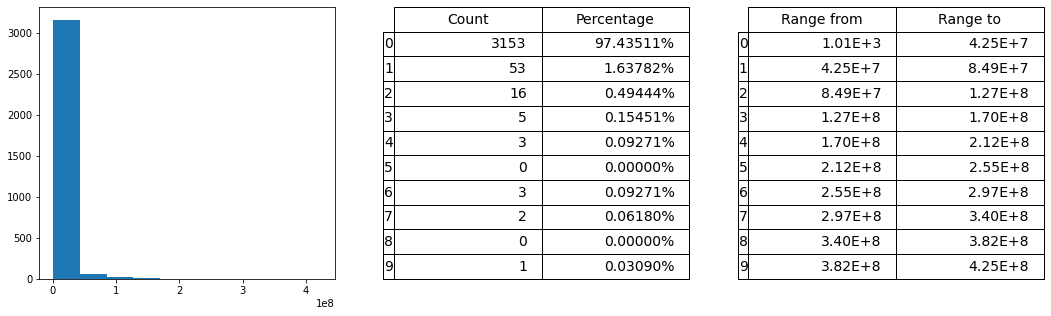

In [7]:
display_histogram(gb_videos, "views")

Na przedstawionym wyżej histogramie widać, że zdecydowana większość filmików ma mniej niż 42.5 miliona wyświetleń.


#### Polubienia i negatywne oceny

##### Polubienia

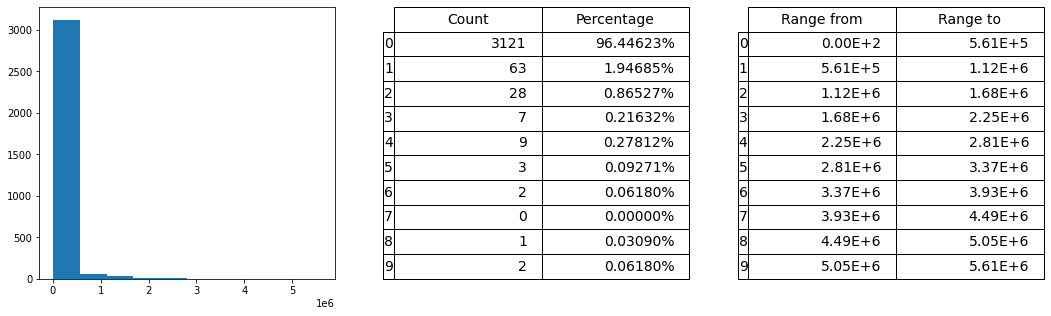

In [8]:
display_histogram(gb_videos, "likes")

Większość filmików, podobnie jak w przypadku histogramu wyświetleń, trafia do pierwszego przedziału histogramu polubień - prawie 95% filmików ma mniej niż około 561 tysięcy polubień. Jest to najprawdopodobniej spowodowane przez rozkład wyświetleń filmików i mechanizm pozostawiania pozytywnej oceny. Aby ocenić filmik należy w niego wejść zwiększając tym samym liczbę wyświetleń. Sprawia to, że polubienia nigdy nie przekroczą liczby wyświetleń.

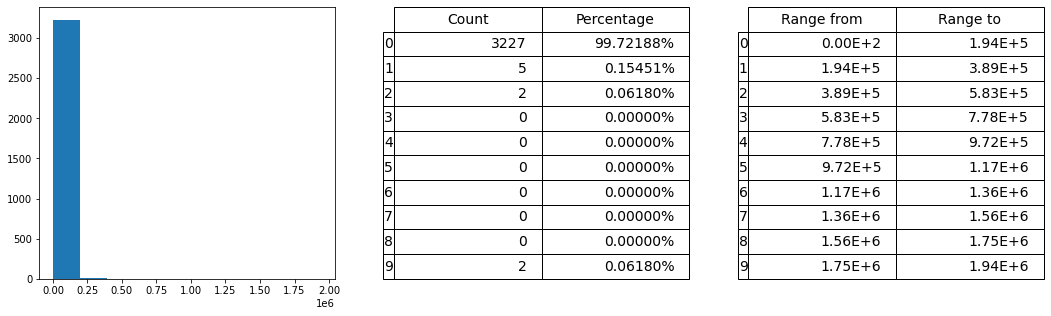

In [9]:
display_histogram(gb_videos, "dislikes")

W przypadku negatywnych ocen otrzymany histogram jest jeszcze bardziej skupiony w pierwszym przedziale - ponad 99% filmików ma mniej niż 194 tysiące negatywnych ocen. Przyczyny takiego rozkładu są prawdopodobnie identyczne jak dla polubień, czyli wpływ na ten histogram mają rozkład wyświetleń filmików i mechanizm pozostawiania oceny.

#### Liczba komentarzy

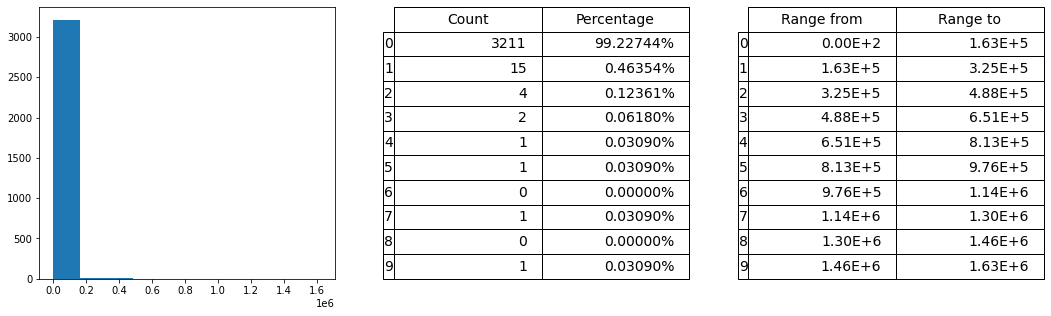

In [10]:
display_histogram(gb_videos, "comment_count")

Zdecydowana większość filmików ma mniej niż około 163 tysiące komentarzy.

#### Wyłączone komentarze

<AxesSubplot:>

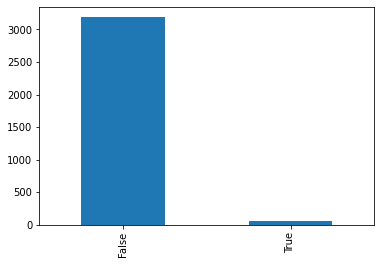

In [11]:
gb_videos["comments_disabled"].value_counts().plot.bar()

Większość filmików ma włączoną opcję zostawiania komentarzy przez użytkowników.

#### Wyłączone oceny

<AxesSubplot:>

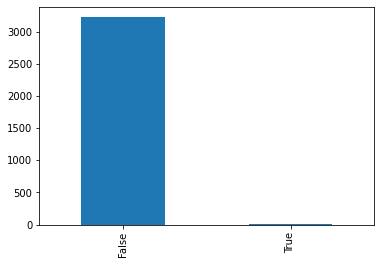

In [12]:
gb_videos["ratings_disabled"].value_counts().plot.bar()

Zdecydowana większość filmików ma włączoną opcję oceniania filmików.

#### Filmik ma błąd albo jest usunięty

<AxesSubplot:>

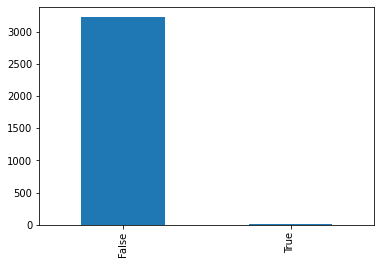

In [13]:
gb_videos["video_error_or_removed"].value_counts().plot.bar()

Bardzo mały odsetek filmików został usunięty albo miał błędy.

#### Analiza dnia trendowania

<AxesSubplot:xlabel='trending_date'>

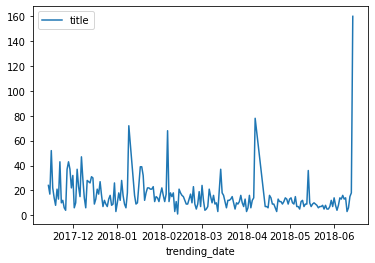

In [14]:
trending = gb_videos[["title", "trending_date"]].groupby("trending_date").count()
trending.plot()

<AxesSubplot:xlabel='trending_day_of_week'>

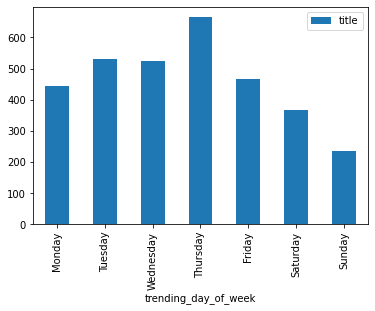

In [15]:
trending = gb_videos[["title", "trending_day_of_week"]].groupby("trending_day_of_week").count().reset_index()

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = trending['trending_day_of_week'].map(mapping)    
trending = trending.iloc[key.argsort()]

trending.plot(kind='bar', x='trending_day_of_week')

### Filmy z USA

#### Wyświetlenia

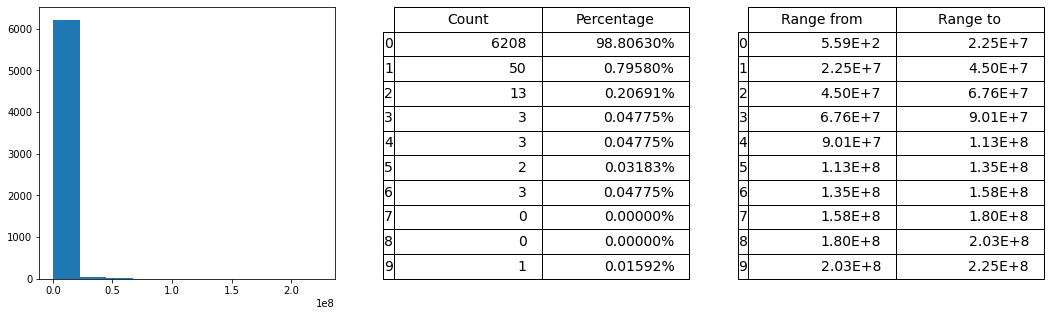

In [16]:
display_histogram(us_videos, "views")

Na przedstawionym wyżej histogramie widać, że zdecydowana większość filmików ma mniej niż 22.5 miliona wyświetleń.


#### Polubienia i negatywne oceny

##### Polubienia

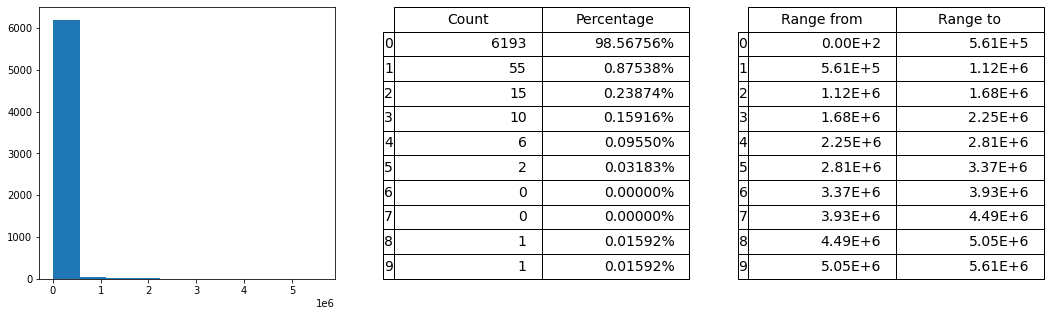

In [17]:
display_histogram(us_videos, "likes")

Większość filmików, podobnie jak w przypadku histogramu wyświetleń, trafia do pierwszego przedziału histogramu polubień - ponad 97% filmików ma mniej niż około 561 tysięcy polubień. Jest to najprawdopodobniej spowodowane przez rozkład wyświetleń filmików i mechanizm pozostawiania pozytywnej oceny. Aby ocenić filmik należy w niego wejść zwiększając tym samym liczbę wyświetleń. Sprawia to, że polubienia nigdy nie przekroczą liczby wyświetleń.

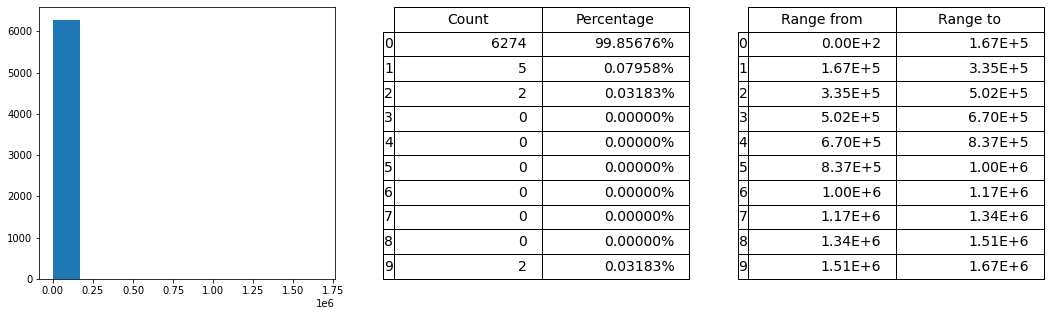

In [18]:
display_histogram(us_videos, "dislikes")

W przypadku negatywnych ocen otrzymany histogram jest jeszcze bardziej skupiony w pierwszym przedziale - ponad 99% filmików ma mniej niż 167 tysiący negatywnych ocen. Przyczyny takiego rozkładu są prawdopodobnie identyczne jak dla polubień, czyli wpływ na ten histogram mają rozkład wyświetleń filmików i mechanizm pozostawiania oceny.

#### Liczba komentarzy

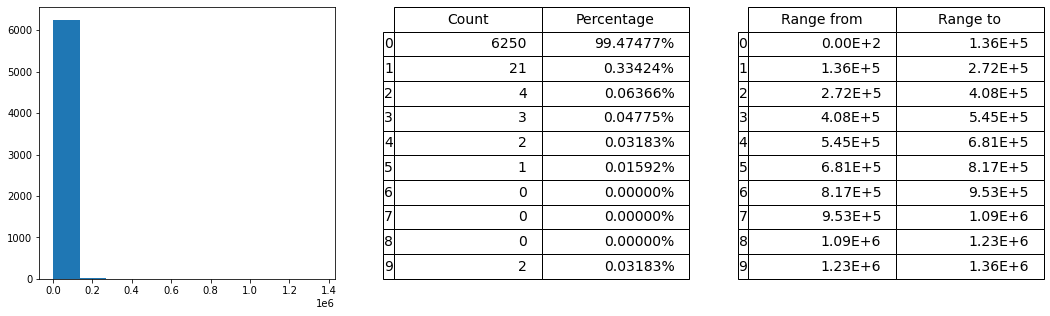

In [19]:
display_histogram(us_videos, "comment_count")

Zdecydowana większość filmików ma mniej niż 136 tysiący komentarzy.

#### Wyłączone komentarze

<AxesSubplot:>

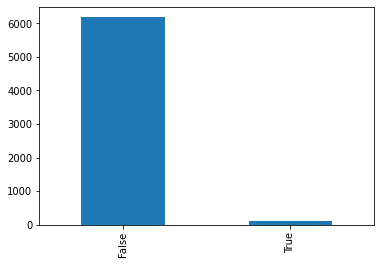

In [20]:
us_videos["comments_disabled"].value_counts().plot.bar()

Większość filmików ma włączoną opcję zostawiania komentarzy przez użytkowników.

#### Wyłączone oceny

<AxesSubplot:>

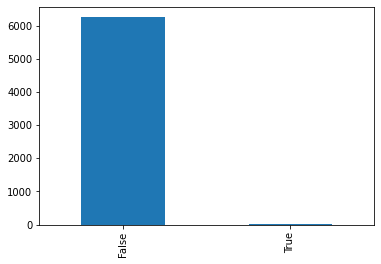

In [21]:
us_videos["ratings_disabled"].value_counts().plot.bar()

Zdecydowana większość filmików ma włączoną opcję oceniania filmików.

#### Filmik ma błąd albo jest usunięty

<AxesSubplot:>

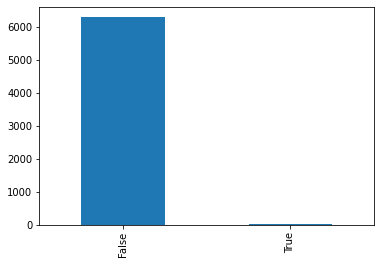

In [22]:
us_videos["video_error_or_removed"].value_counts().plot.bar()

Bardzo mały odsetek filmików został usunięty albo miał błędy.

#### Analiza dnia trendowania

<AxesSubplot:xlabel='trending_date'>

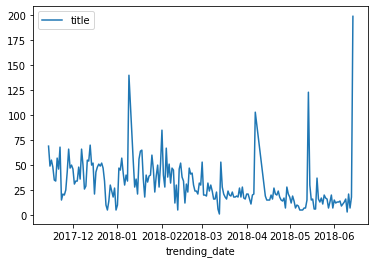

In [23]:
trending = us_videos[["title", "trending_date"]].groupby("trending_date").count()
trending.plot()

<AxesSubplot:xlabel='trending_day_of_week'>

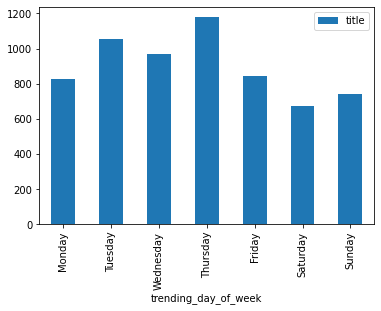

In [24]:
trending = us_videos[["title", "trending_day_of_week"]].groupby("trending_day_of_week").count().reset_index()

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = trending['trending_day_of_week'].map(mapping)    
trending = trending.iloc[key.argsort()]

trending.plot(kind='bar', x='trending_day_of_week')

### Inne wnioski

Kolumna category_id w obu zbiorach danych zawiera bardzo dużo braków. 

## Zmiana reprezentacji danych

Dane które będą używane do tworzenia atrybutów tekstowych to kolumny: 
- title
- channel_title
- tags
- views
- likes
- dislikes
- comment_count
- comments_disabled
- ratings disabled
- video_error_or_removed
- description

Z kolumn description i title atrybuty są tworzone na podstawie różnych cech tych ciągów znaków.

Atrybut video_id nie może zostać wykorzystany, ponieważ nie opisuje w żaden sposób filmu, a jest tylko przypadkowym ciągiem znaków. Data trending_date także nie ma większego znaczenia.

In [25]:
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "no", "nor", "not", "off", "out", "over", "shouldn't", "same", "too", "under", "why",
            "why's", "won't", "wouldn't"]

punctuation1 = "'*.,:;-_?!(){}[]<>|&’$‘+-=”“►▶/s"
punctuation2 = ["``", "''", "...", "--", "'s"]

In [26]:
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text 

class SimpleTokenizer():
    @staticmethod
    def tokenize(text):
        return text.split(" ")
    
class NltkTokenizer():
    @staticmethod
    def tokenize(text):
        return nltk.word_tokenize(text) 
    
class Tokenizer():
    @staticmethod
    def tokenize(text):
        text = BeforeTokenizationNormalizer.normalize(text)
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            match = None
            if (RE_HASHTAG.search(token)) or (RE_EMOTICONS.search(token)) or (RE_HTTP.search(token)):
                match = True
            if match is not None:
                pass
            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1
            
        porter = nltk.PorterStemmer()
        for i in range(len(tokens)):
            tokens[i] = porter.stem(tokens[i])
            
        tokens1 = []
        for ii in tokens:
            if (ii not in stopwords) and (ii not in punctuation1) and (ii not in punctuation2):
                tokens1.append(ii)
        return tokens1


In [27]:
gb_videos["description"] = gb_videos["description "].apply(lambda row: str(row))
gb_videos["description_tokens"] = gb_videos["description"].apply(lambda row: Tokenizer.tokenize(row))
gb_videos["title_tokens"] = gb_videos["title"].apply(lambda row: Tokenizer.tokenize(row))
gb_videos["tags_tokens"] = gb_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [28]:
us_videos["description"] = us_videos["description "].apply(lambda row: str(row))
us_videos["description_tokens"] = us_videos["description"].apply(lambda row: Tokenizer.tokenize(row))
us_videos["title_tokens"] = us_videos["title"].apply(lambda row: Tokenizer.tokenize(row))
us_videos["tags_tokens"] = us_videos["tags"].apply(lambda row: row.lower().replace('"', "").split("|"))

In [29]:
wordsTitleGB = Counter()
wordsDescriptionGB = Counter()
wordsTagsGB = Counter()

for i in gb_videos["title_tokens"]:
    wordsTitleGB.update(i)

for i in gb_videos["description_tokens"]:
    wordsDescriptionGB.update(i)

for i in gb_videos["tags_tokens"]:
    wordsTagsGB.update(i)

In [30]:
wordsTitleUS = Counter()
wordsDescriptionUS = Counter()
wordsTagsUS = Counter()

for i in us_videos["title_tokens"]:
    wordsTitleUS.update(i)

for i in us_videos["description_tokens"]:
    wordsDescriptionUS.update(i)

for i in us_videos["tags_tokens"]:
    wordsTagsUS.update(i)

Poniżej zbiór najczęściej występujących tokenów w tagach, opisach i tytułach. Najczęściej występujące tokeny mogą być brane jako atrybuty.

In [31]:
wordsTitleGB.most_common(30)

[('offici', 432),
 ('video', 338),
 ('trailer', 227),
 ('ft', 137),
 ('2018', 135),
 ('music', 127),
 ('new', 116),
 ('war', 108),
 ('live', 106),
 ('2017', 100),
 ('star', 95),
 ('audio', 94),
 ('hd', 89),
 ('trump', 83),
 ('last', 77),
 ('2', 71),
 ('feat', 71),
 ('talk', 71),
 ('vs', 68),
 ('movi', 63),
 ('(2018)', 61),
 ('day', 58),
 ('love', 58),
 ('1', 56),
 ('mv', 56),
 ('full', 56),
 ('christma', 55),
 ('perform', 55),
 ('jedi', 54),
 ('black', 52)]

In [32]:
wordsDescriptionGB.most_common(30)

[('video', 2059),
 ('show', 1431),
 ('thi', 1420),
 ('music', 1390),
 ('live', 1025),
 ('new', 964),
 ('jimmi', 961),
 ('hi', 854),
 ('twitter', 844),
 ('late', 841),
 ('get', 765),
 ('youtub', 756),
 ('star', 753),
 ('channel', 751),
 ('instagram', 740),
 ('us', 738),
 ('facebook', 736),
 ('now', 681),
 ('offici', 651),
 ('can', 635),
 ('watch', 622),
 ('news', 616),
 ('like', 614),
 ('subscrib', 608),
 ('will', 592),
 ('one', 592),
 ('kimmel', 571),
 ('wa', 563),
 ('tmz', 559),
 ('love', 528)]

In [33]:
wordsTagsGB.most_common(30)

[('funny', 380),
 ('comedy', 331),
 ('music', 266),
 ('[none]', 175),
 ('interview', 175),
 ('humor', 165),
 ('trailer', 155),
 ('video', 146),
 ('late night', 143),
 ('comedian', 140),
 ('pop', 140),
 ('celebrity', 139),
 ('talk show', 139),
 ('television', 134),
 ('celebrities', 128),
 ('live', 128),
 ('jokes', 127),
 ('funny video', 126),
 ('hollywood', 124),
 ('2018', 111),
 ('clip', 109),
 ('official', 109),
 ('rap', 109),
 ('hip hop', 107),
 ('famous', 103),
 ('show', 101),
 ('music video', 101),
 ('vlog', 99),
 ('star wars', 97),
 ('comedic', 95)]

In [34]:
wordsTitleUS.most_common(30)

[('offici', 487),
 ('video', 327),
 ('2018', 309),
 ('trailer', 303),
 ('vs', 177),
 ('2017', 175),
 ('new', 168),
 ('live', 167),
 ('make', 165),
 ('ft', 155),
 ('first', 141),
 ('thi', 139),
 ('hd', 137),
 ('day', 131),
 ('music', 127),
 ('2', 126),
 ('game', 125),
 ('show', 122),
 ('get', 120),
 ('audio', 118),
 ('star', 117),
 ("n't", 110),
 ('whi', 110),
 ('war', 106),
 ('makeup', 104),
 ('hi', 100),
 ('movi', 98),
 ('tri', 96),
 ('world', 94),
 ('espn', 91)]

In [35]:
wordsDescriptionUS.most_common(30)

[('video', 5144),
 ('follow', 4304),
 ('thi', 4157),
 ('subscrib', 3427),
 ('twitter', 3308),
 ('facebook', 3027),
 ('instagram', 2949),
 ('watch', 2934),
 ('get', 2856),
 ('like', 2697),
 ('music', 2685),
 ('show', 2652),
 ('us', 2408),
 ('new', 2196),
 ('youtub', 1996),
 ('channel', 1885),
 ('live', 1677),
 ('news', 1637),
 ('jimmi', 1630),
 ('use', 1557),
 ('hi', 1503),
 ('make', 1483),
 ('late', 1437),
 ('can', 1419),
 ('»', 1415),
 ('product', 1398),
 ('wa', 1310),
 ('now', 1243),
 ('check', 1210),
 ('one', 1210)]

In [36]:
wordsTagsUS.most_common(30)

[('funny', 741),
 ('comedy', 657),
 ('humor', 282),
 ('music', 264),
 ('[none]', 257),
 ('interview', 238),
 ('comedian', 230),
 ('celebrity', 230),
 ('television', 229),
 ('news', 223),
 ('trailer', 221),
 ('celebrities', 216),
 ('talk show', 214),
 ('video', 214),
 ('how to', 210),
 ('late night', 198),
 ('2018', 197),
 ('funny video', 195),
 ('science', 193),
 ('pop', 192),
 ('live', 190),
 ('hollywood', 184),
 ('jokes', 184),
 ('food', 184),
 ('review', 180),
 ('nbc', 180),
 ('show', 174),
 ('clip', 162),
 ('entertainment', 161),
 ('sports', 156)]

In [37]:
AT_GB = gb_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["title_emoticons"] = gb_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_GB["title_hashtag"] = gb_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_GB["title_interpunction"] = gb_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["description_length"] = gb_videos["description"].apply(lambda row: len(str(row)))
AT_GB["description_uppercase"] = gb_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_GB["description_link"] = gb_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_GB["description_emoticons"] = gb_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_GB["description_hashtag"] = gb_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_GB["description_interpunction"] = gb_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_GB["tag_number"] = gb_videos["tags"].apply(lambda row: len(row.split("|")))

for tokenTitle in wordsTitleGB.most_common(10):
    AT_GB["TTitle_"+tokenTitle[0]] =  gb_videos["title_tokens"].apply(lambda row: tokenTitle[0] in row)
    
for tokenDesc in wordsDescriptionGB.most_common(10):
    AT_GB["TDesc_"+tokenDesc[0]] =  gb_videos["description_tokens"].apply(lambda row: tokenDesc[0] in row)
    
for tokenTag in wordsTagsGB.most_common(10):
    AT_GB["TTags_"+tokenTag[0]] =  gb_videos["tags_tokens"].apply(lambda row: tokenTag[0] in row)

display(AT_GB)

AT_GB.to_csv("AT_GB.csv") 

<ipython-input-37-1e042a5792cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_GB["title_length"] = gb_videos["title"].apply(lambda row: len(row))
<ipython-input-37-1e042a5792cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_GB["title_uppercase"] = gb_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
<ipython-input-37-1e042a5792cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,...,TTags_funny,TTags_comedy,TTags_music,TTags_[none],TTags_interview,TTags_humor,TTags_trailer,TTags_video,TTags_late night,TTags_comedian
video_id,,,,,,,,,,,,,,,,,,,,,
-3VBPAZPTQI,404690,16002,306,858,False,False,False,48,0.812500,False,...,False,False,False,False,False,False,False,False,False,False
-43MBOJnVks,1758599,16188,832,2182,False,False,False,33,0.727273,False,...,False,False,False,False,False,False,True,False,False,False
-5WBCrazSfg,345486,6810,121,688,False,False,False,70,0.114286,False,...,False,False,False,False,False,False,False,False,False,False
-5aaJJQFvOg,1770509,163869,2704,7269,False,False,False,44,0.227273,False,...,False,False,False,False,False,False,False,False,False,False
-7tSTUR7FG0,4651793,251125,1013,12150,False,False,False,33,0.303030,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwEn-ambXLw,246809,8626,146,328,False,False,False,57,0.157895,False,...,False,False,False,False,False,False,False,False,False,False
zwrlJwed2mQ,107312,763,3,26,False,False,False,60,0.333333,False,...,False,False,False,False,False,False,False,False,False,False
zxGg8QqWrRQ,124057,1981,98,347,False,False,False,89,0.213483,False,...,False,False,True,False,True,False,False,False,False,False


In [38]:
AT_US = us_videos[["views", "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "video_error_or_removed"]]

AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["title_emoticons"] = us_videos["title"].apply(lambda row: RE_EMOTICONS.search(str(row))!=None)
AT_US["title_hashtag"] = us_videos["title"].apply(lambda row: RE_HASHTAG.search(str(row))!=None)
AT_US["title_interpunction"] = us_videos["title"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["description_length"] = us_videos["description"].apply(lambda row: len(str(row)))
AT_US["description_uppercase"] = us_videos["description"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
AT_US["description_link"] = us_videos["description"].apply(lambda row: RE_HTTP.search(row)!=None)
AT_US["description_emoticons"] = us_videos["description"].apply(lambda row: RE_EMOTICONS.search(row)!=None)
AT_US["description_hashtag"] = us_videos["description"].apply(lambda row: RE_HASHTAG.search(row)!=None)
AT_US["description_interpunction"] = us_videos["description"].apply(lambda row: len(''.join(x for x in row if x in punctuation1)))
AT_US["tag_number"] = us_videos["tags"].apply(lambda row: len(row.split("|")))

for tokenTitle in wordsTitleUS.most_common(10):
    AT_US["TTitle_"+tokenTitle[0]] =  us_videos["title_tokens"].apply(lambda row: tokenTitle[0] in row)
    
for tokenDesc in wordsDescriptionUS.most_common(10):
    AT_US["TDesc_"+tokenDesc[0]] =  us_videos["description_tokens"].apply(lambda row: tokenDesc[0] in row)
    
for tokenTag in wordsTagsUS.most_common(10):
    AT_US["TTags_"+tokenTag[0]] =  us_videos["tags_tokens"].apply(lambda row: tokenTag[0] in row)

display(AT_US)

AT_US.to_csv("AT_US.csv") 

<ipython-input-38-05181d104afa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_US["title_length"] = us_videos["title"].apply(lambda row: len(row))
<ipython-input-38-05181d104afa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_US["title_uppercase"] = us_videos["title"].apply(lambda row: 1-float(len(''.join(x for x in row if not x.isupper())))/len(row))
<ipython-input-38-05181d104afa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length,title_uppercase,title_emoticons,...,TTags_funny,TTags_comedy,TTags_humor,TTags_music,TTags_[none],TTags_interview,TTags_comedian,TTags_celebrity,TTags_television,TTags_news
video_id,,,,,,,,,,,,,,,,,,,,,
-0CMnp02rNY,800359,9773,332,423,False,False,False,74,0.121622,False,...,True,False,False,False,False,True,False,False,False,False
-0NYY8cqdiQ,563746,4429,54,94,False,False,False,75,0.106667,False,...,True,False,False,False,False,True,False,False,False,False
-1Hm41N0dUs,2058516,41248,580,1484,False,False,False,53,0.132075,False,...,True,True,False,False,False,False,True,False,False,False
-1yT-K3c6YI,231341,7734,212,846,False,False,False,51,0.764706,False,...,False,False,False,False,False,False,False,False,False,False
-2RVw2_QyxQ,71089,460,27,20,False,False,False,30,0.100000,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwEn-ambXLw,241668,8478,144,328,False,False,False,57,0.157895,False,...,False,False,False,False,False,False,False,False,False,False
zxUwbflE1SY,225280,5770,150,1312,False,False,False,52,0.134615,False,...,True,False,False,False,False,False,False,False,False,False
zxwfDlhJIpw,8442986,166520,19462,48467,False,False,False,34,0.000000,False,...,False,False,False,False,False,False,False,False,False,False


# Checkpoint 2

Importowanie bibliotek, funkcje pomocnicze i stałe

In [39]:
import urllib.request

RUN_REQUEST = False

def download_thumbnails(data, output_path):
    for video_id in data:
        try:
            urllib.request.urlretrieve("https://img.youtube.com/vi/" + video_id + "/0.jpg", output_path + video_id + ".jpg")
        except:
            print("Nie znaleziono " + video_id)

def makeArray(text):
    if text !="[]":
        return text.replace("'", "").replace("[", "").replace("]", "").split(", ")
    else:
        return []

Pobieranie thumbnail w większym rozmiarze

In [40]:
if RUN_REQUEST:
    download_thumbnails(gb_videos.index, "./data/thumbnails/GB/")

In [41]:
if RUN_REQUEST:
    download_thumbnails(us_videos.index, "./data/thumbnails/US/")

## Podstawowa analiza

Biblioteki, funkcje pomocnicze i stałe

In [42]:
from skimage import data, io, filters, color
import cv2
from tqdm.auto import tqdm

### UK

#### Przestrzeń barw RGB

  0%|          | 0/3236 [00:00<?, ?it/s]

Couldn't open 387 files


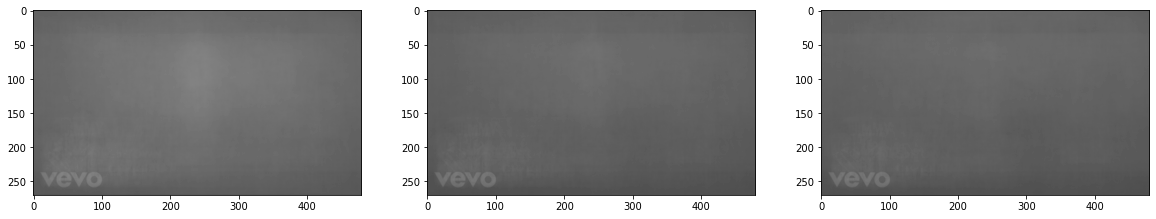

In [43]:
no_load = 0
loaded = 0

red = np.zeros((270, 480))
green = np.zeros((270, 480))
blue = np.zeros((270, 480))

for id in tqdm(gb_videos.index):
    try:
        image = io.imread("./data/thumbnails/GB/" + id + ".jpg")
        image = image[45:315,:,:]
        loaded += 1
        red = red + (image[:,:,0] / 255)
        green = green + (image[:,:,1] / 255)
        blue = blue + (image[:,:,2] / 255)
    except:
        no_load += 1

print("Couldn't open {} files".format(no_load))

red = red / loaded
green = green / loaded
blue = blue / loaded

f, ax = plt.subplots(1, 3, figsize=(20,15))
ax[0].imshow(red, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(green, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(blue, cmap='gray', vmin=0, vmax=1)

plt.show()

#### Przestrzeń barw HSV

  0%|          | 0/3236 [00:00<?, ?it/s]

Couldn't open 387 files


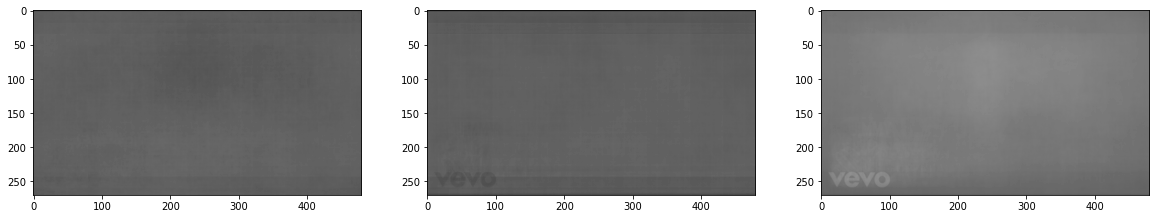

In [44]:
no_load = 0
loaded = 0

hue = np.zeros((270, 480))
saturation = np.zeros((270, 480))
value = np.zeros((270, 480))

for id in tqdm(gb_videos.index):
    try:
        image = io.imread("./data/thumbnails/GB/" + id + ".jpg")
        image = image[45:315,:,:]
        hsv = color.rgb2hsv(image)
        loaded += 1
        # print("H: {} | S: {} | V: {}".format(np.max(hsv[:,:,0]), np.max(hsv[:,:,0]), np.max(hsv[:,:,0])))
        hue = hue + hsv[:,:,0]
        saturation = saturation + hsv[:,:,1]
        value = value + hsv[:,:,2]
    except:
        no_load += 1

print("Couldn't open {} files".format(no_load))

hue = hue / loaded
saturation = saturation / loaded
value = value / loaded

f, ax = plt.subplots(1, 3, figsize=(20,15))
ax[0].imshow(hue, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(saturation, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(value, cmap='gray', vmin=0, vmax=1)

plt.show()

### USA

#### Przestrzeń barw RGB

  0%|          | 0/6283 [00:00<?, ?it/s]

Couldn't open 489 files


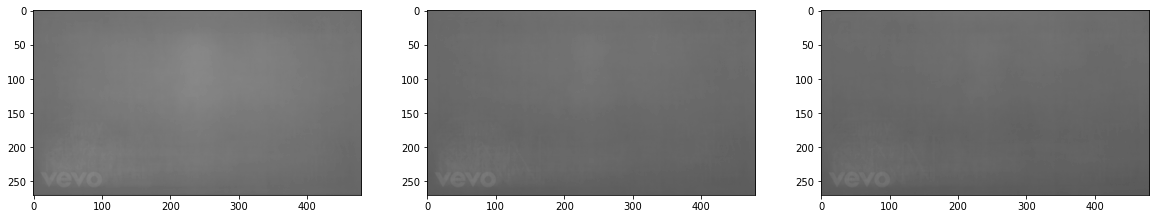

In [45]:
no_load = 0
loaded = 0

red = np.zeros((270, 480))
green = np.zeros((270, 480))
blue = np.zeros((270, 480))

for id in tqdm(us_videos.index):
    try:
        image = io.imread("./data/thumbnails/US/" + id + ".jpg")
        image = image[45:315,:,:]
        loaded += 1
        red = red + (image[:,:,0] / 255)
        green = green + (image[:,:,1] / 255)
        blue = blue + (image[:,:,2] / 255)
    except:
        no_load += 1

print("Couldn't open {} files".format(no_load))

red = red / loaded
green = green / loaded
blue = blue / loaded

f, ax = plt.subplots(1, 3, figsize=(20,15))
ax[0].imshow(red, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(green, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(blue, cmap='gray', vmin=0, vmax=1)

plt.show()

#### Przestrzeń barw HSV

  0%|          | 0/6283 [00:00<?, ?it/s]

Couldn't open 489 files


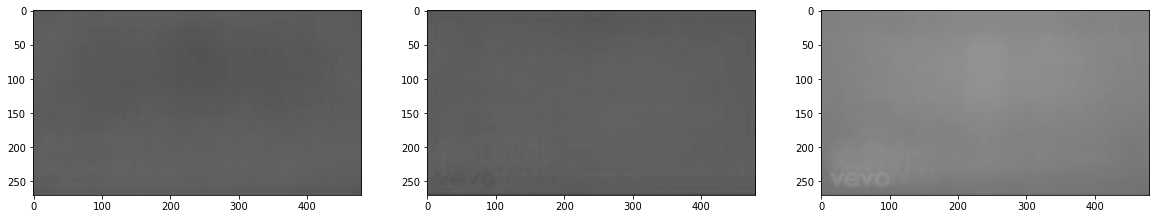

In [46]:
no_load = 0
loaded = 0

hue = np.zeros((270, 480))
saturation = np.zeros((270, 480))
value = np.zeros((270, 480))

for id in tqdm(us_videos.index):
    try:
        image = io.imread("./data/thumbnails/US/" + id + ".jpg")
        image = image[45:315,:,:]
        hsv = color.rgb2hsv(image)
        loaded += 1
        # print("H: {} | S: {} | V: {}".format(np.max(hsv[:,:,0]), np.max(hsv[:,:,0]), np.max(hsv[:,:,0])))
        hue = hue + hsv[:,:,0]
        saturation = saturation + hsv[:,:,1]
        value = value + hsv[:,:,2]
    except:
        no_load += 1

print("Couldn't open {} files".format(no_load))

hue = hue / loaded
saturation = saturation / loaded
value = value / loaded

f, ax = plt.subplots(1, 3, figsize=(20,15))
ax[0].imshow(hue, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(saturation, cmap='gray', vmin=0, vmax=1)
ax[2].imshow(value, cmap='gray', vmin=0, vmax=1)

plt.show()

## OCR

Biblioteki, funkcje pomocnicze i stałe

In [47]:
from skimage import data, io, filters
import cv2
import pytesseract
import matplotlib.pyplot as plt
from IPython.display import clear_output

READ_CSV = True

### UK

In [48]:
if not READ_CSV:
    AG_GB = pd.DataFrame()

    lightRed = []
    lightGreen = []
    lightBlue = []
    sobelFilter = []
    text = []
    i=0
    for id in gb_videos.index:
        clear_output(wait=True)
        print("Processing text on images: "+str('%.2f'%(i/len(gb_videos)*100))+"%")
        i=i+1
        empty = False
        try:
            image = io.imread("./data/thumbnails/GB/"+id+".jpg")
            image = image[45:315,:,:]
        except:
            image = np.ones(270*480*3).reshape([270, 480, 3])
            empty = True
        lightRed.append(image[:,:,0].mean())
        lightGreen.append(image[:,:,1].mean())
        lightBlue.append(image[:,:,2].mean())
        sobelFilter.append(filters.sobel(image).mean())

        words = []
        if not empty:
            pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            thresh1 = cv2.adaptiveThreshold(gray.copy(),255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,251,-100)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 4))
            dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
            contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                            cv2.CHAIN_APPROX_NONE)
            im2 = image.copy()
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                if (w>20) and (h>20):
                    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    # Cropping the text block for giving input to OCR
                    cropped = thresh1[y:y + h, x:x + w]
                    detected_text = pytesseract.image_to_string(cropped)
                    if detected_text.replace("\n","").replace("  ","") not in [""," "]:
                        for token in Tokenizer.tokenize(detected_text):
                            if (len(token)>2) and (wordsDescriptionGB[token]>1):
                                words.append(token)
            #fig, ax = plt.subplots(2,2, figsize=(15,15))
            #ax[0,0].imshow(im2)
            #ax[0,1].imshow(gray, cmap=plt.get_cmap('gray'))
            #ax[1,0].imshow(thresh1, cmap=plt.get_cmap('gray'))
            #ax[1,1].imshow(dilation, cmap=plt.get_cmap('gray'))
            #plt.show()
        text.append(words)
        
    AG_GB["text"] = text
    AG_GB["lightRed"] = lightRed
    AG_GB["lightGreen"] = lightGreen
    AG_GB["lightBlue"] = lightBlue
    AG_GB["sobelFilter"] = sobelFilter
    
    counter = Counter()
    for i in AG_GB["text"]:
        counter.update(i)
    for text in counter.most_common(10):
        AG_GB["TThumbText_"+text[0]] =  AG_GB["text"].apply(lambda row: text[0] in row)
        
    print(counter.most_common(30))
    AG_GB.to_csv("AG_GB.csv")  

In [49]:
if READ_CSV:      
    AG_GB = pd.read_csv("AG_GB.csv", sep=',', index_col = 0)
    AG_GB['text'] = AG_GB['text'].apply(makeArray)
    AG_GB = AG_GB.drop("text", axis=1)

In [50]:
display(AG_GB)

,lightRed,lightGreen,lightBlue,sobelFilter,TThumbText_offici,TThumbText_trailer,TThumbText_vevo,TThumbText_live,TThumbText_news,TThumbText_jimmi,TThumbText_beatdown,TThumbText_watch,TThumbText_happen,TThumbText_mum
0,156.558611,123.349884,109.113758,0.084025,False,False,False,False,False,False,False,False,False,False
1,124.824082,123.233727,118.124275,0.035754,False,False,False,False,False,False,False,False,False,False
2,111.618156,107.661481,95.612569,0.078878,False,False,False,False,False,False,False,False,False,False
3,138.034213,103.151991,116.714938,0.088099,False,False,False,False,False,False,False,False,False,False
4,152.275309,152.125100,153.678511,0.034287,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,134.342554,128.625779,129.624105,0.024557,False,False,False,False,False,False,False,False,False,False
3232,35.066890,41.795887,53.680455,0.039151,False,False,False,False,False,False,False,False,False,False
3233,114.012369,82.459390,84.419877,0.091477,False,False,False,False,False,False,False,False,False,False
3234,78.359537,117.655455,128.317770,0.142863,False,False,False,False,False,False,False,False,False,False


### USA

In [51]:
if not READ_CSV:
    AG_US = pd.DataFrame()

    lightRed = []
    lightGreen = []
    lightBlue = []
    sobelFilter = []
    text = []
    i=0
    for id in us_videos.index:
        clear_output(wait=True)
        print("Processing text on images: "+str('%.2f'%(i/len(us_videos)*100))+"%")
        i=i+1
        empty = False
        try:
            image = io.imread("./data/thumbnails/US/"+id+".jpg")
            image = image[45:315,:,:]
        except:
            image = np.ones(270*480*3).reshape([270, 480, 3])
            empty = True
        lightRed.append(image[:,:,0].mean())
        lightGreen.append(image[:,:,1].mean())
        lightBlue.append(image[:,:,2].mean())
        sobelFilter.append(filters.sobel(image).mean())

        words = []
        if not empty:
            pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            thresh1 = cv2.adaptiveThreshold(gray.copy(),255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,251,-100)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 4))
            dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
            contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                            cv2.CHAIN_APPROX_NONE)
            im2 = image.copy()
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                if (w>20) and (h>20):
                    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    # Cropping the text block for giving input to OCR
                    cropped = thresh1[y:y + h, x:x + w]
                    detected_text = pytesseract.image_to_string(cropped)
                    if detected_text.replace("\n","").replace("  ","") not in [""," "]:
                        for token in Tokenizer.tokenize(detected_text):
                            if (len(token)>2) and (wordsDescriptionUS[token]>1):
                                words.append(token)
            #fig, ax = plt.subplots(2,2, figsize=(15,15))
            #ax[0,0].imshow(im2)
            #ax[0,1].imshow(gray, cmap=plt.get_cmap('gray'))
            #ax[1,0].imshow(thresh1, cmap=plt.get_cmap('gray'))
            #ax[1,1].imshow(dilation, cmap=plt.get_cmap('gray'))
            #plt.show()
        text.append(words)
    AG_US["text"] = text
    AG_US["lightRed"] = lightRed
    AG_US["lightGreen"] = lightGreen
    AG_US["lightBlue"] = lightBlue
    AG_US["sobelFilter"] = sobelFilter
    
    counter = Counter()
    for i in AG_US["text"]:
        counter.update(i)
    for text in counter.most_common(10):
        AG_US["TThumbText_"+text[0]] =  AG_US["text"].apply(lambda row: text[0] in row)
        
    print(counter.most_common(30))

    AG_US.to_csv("AG_US.csv")  

In [52]:
if READ_CSV:
    AG_US = pd.read_csv("AG_US.csv", sep=',', index_col = 0)
    AG_US['text'] =AG_US['text'].apply(makeArray)
    AG_US = AG_US.drop("text", axis=1)

In [53]:
display(AG_US)

,lightRed,lightGreen,lightBlue,sobelFilter,TThumbText_news,TThumbText_offici,TThumbText_origin,TThumbText_jimmi,TThumbText_trailer,TThumbText_first,TThumbText_watch,TThumbText_happen,TThumbText_vevo,TThumbText_movi
0,120.631852,125.198580,133.230401,0.110362,False,False,False,False,False,False,False,False,False,False
1,130.378434,137.141698,145.877693,0.109129,False,False,False,False,False,False,False,False,False,False
2,116.568981,95.533148,90.406427,0.066549,False,False,False,False,False,False,False,False,False,False
3,164.492492,133.028256,134.954360,0.120691,False,False,False,False,False,False,False,False,False,False
4,121.184074,137.213140,149.353364,0.095754,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6278,134.342554,128.625779,129.624105,0.024557,False,False,False,False,False,False,False,False,False,False
6279,144.210463,143.301427,151.025926,0.035990,False,False,False,False,False,False,False,False,False,False
6280,156.705401,157.741798,153.395849,0.016899,False,False,False,False,False,False,False,False,False,False
6281,1.000000,1.000000,1.000000,0.000000,False,False,False,False,False,False,False,False,False,False


## Klasyfikacja

Biblioteki, funkcje pomocnicze, wspólne zmienne i stałe

In [54]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tqdm.auto import tqdm

model = ResNet50(weights='imagenet')

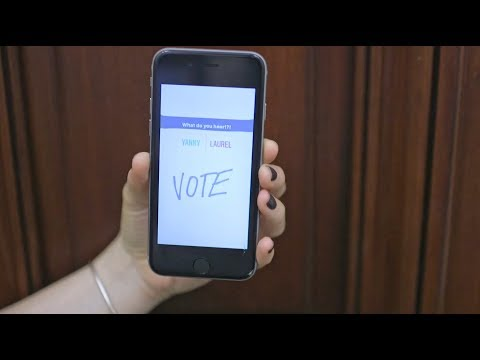

Predicted: [('n03584254', 'iPod', 0.64892924), ('n02992529', 'cellular_telephone', 0.18888845), ('n03777754', 'modem', 0.02961525), ('n03485407', 'hand-held_computer', 0.027228469), ('n06359193', 'web_site', 0.014069771)]


In [55]:
from IPython.display import Image, display

img_path = "data/thumbnails/GB/1qsRU7C_Gp0.jpg"

display(Image(filename=img_path))

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

### UK

In [56]:
results = []
no_load = 0

for id in tqdm(gb_videos.index):
    try:
        img = image.load_img("./data/thumbnails/GB/" + id + ".jpg", target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        decoded = decode_predictions(preds, top=1)[0]
        decoded = [x[1] for x in decoded]
        results.append(decoded[0])
    except:
        no_load = no_load + 1
        results.append("")

AG_GB["thumbnailDescription"] = results

print("Couldn't open {} files".format(no_load))

  0%|          | 0/3236 [00:00<?, ?it/s]

Couldn't open 387 files


In [57]:
AG_GB.head()

,lightRed,lightGreen,lightBlue,sobelFilter,TThumbText_offici,TThumbText_trailer,TThumbText_vevo,TThumbText_live,TThumbText_news,TThumbText_jimmi,TThumbText_beatdown,TThumbText_watch,TThumbText_happen,TThumbText_mum,thumbnailDescription
0,156.558611,123.349884,109.113758,0.084025,False,False,False,False,False,False,False,False,False,False,lipstick
1,124.824082,123.233727,118.124275,0.035754,False,False,False,False,False,False,False,False,False,False,television
2,111.618156,107.661481,95.612569,0.078878,False,False,False,False,False,False,False,False,False,False,web_site
3,138.034213,103.151991,116.714938,0.088099,False,False,False,False,False,False,False,False,False,False,television
4,152.275309,152.125100,153.678511,0.034287,False,False,False,False,False,False,False,False,False,False,mountain_bike


In [58]:
data = AG_GB["thumbnailDescription"].values.tolist()

counter = Counter()

for x in data:
    counter.update({x: 1})

counter.most_common(50)

[('television', 1096),
 ('web_site', 632),
 ('', 387),
 ('monitor', 67),
 ('theater_curtain', 52),
 ('groom', 51),
 ('sax', 47),
 ('comic_book', 46),
 ('microphone', 31),
 ('stage', 28),
 ('wig', 26),
 ('abaya', 23),
 ('book_jacket', 21),
 ('home_theater', 21),
 ('scoreboard', 17),
 ('sunglasses', 17),
 ('barbershop', 15),
 ('screen', 15),
 ('suit', 14),
 ('Windsor_tie', 14),
 ('bow_tie', 14),
 ('mountain_bike', 13),
 ('cellular_telephone', 11),
 ('lipstick', 10),
 ('envelope', 10),
 ('fountain', 9),
 ('spotlight', 9),
 ('lab_coat', 9),
 ('digital_clock', 9),
 ('street_sign', 9),
 ('cash_machine', 8),
 ('bubble', 7),
 ('cinema', 7),
 ('jersey', 7),
 ('hair_spray', 7),
 ('bannister', 7),
 ('brassiere', 6),
 ('mask', 6),
 ('marimba', 6),
 ('window_shade', 6),
 ('electric_guitar', 6),
 ('chain_mail', 6),
 ('washbasin', 6),
 ('syringe', 6),
 ('cloak', 6),
 ('dumbbell', 5),
 ('feather_boa', 5),
 ('fur_coat', 5),
 ('candle', 5),
 ('ice_lolly', 5)]

### USA

In [59]:
results = []
no_load = 0

for id in tqdm(us_videos.index):
    try:
        img = image.load_img("./data/thumbnails/US/" + id +".jpg", target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        decoded = decode_predictions(preds, top=1)[0]
        decoded = [x[1] for x in decoded]
        results.append(decoded[0])
    except:
        no_load = no_load + 1
        results.append("")

AG_US["thumbnailDescription"] = results

print("Couldn't open {} files".format(no_load))

  0%|          | 0/6283 [00:00<?, ?it/s]

Couldn't open 488 files


In [60]:
AG_US.head()

,lightRed,lightGreen,lightBlue,sobelFilter,TThumbText_news,TThumbText_offici,TThumbText_origin,TThumbText_jimmi,TThumbText_trailer,TThumbText_first,TThumbText_watch,TThumbText_happen,TThumbText_vevo,TThumbText_movi,thumbnailDescription
0,120.631852,125.198580,133.230401,0.110362,False,False,False,False,False,False,False,False,False,False,television
1,130.378434,137.141698,145.877693,0.109129,False,False,False,False,False,False,False,False,False,False,television
2,116.568981,95.533148,90.406427,0.066549,False,False,False,False,False,False,False,False,False,False,envelope
3,164.492492,133.028256,134.954360,0.120691,False,False,False,False,False,False,False,False,False,False,web_site
4,121.184074,137.213140,149.353364,0.095754,False,False,False,False,False,False,False,False,False,False,web_site


In [61]:
data = AG_US["thumbnailDescription"].values.tolist()

counter = Counter()

for x in data:
    counter.update({x: 1})

counter.most_common(50)

[('television', 1950),
 ('web_site', 1269),
 ('', 488),
 ('monitor', 146),
 ('groom', 115),
 ('comic_book', 102),
 ('theater_curtain', 61),
 ('abaya', 53),
 ('stage', 50),
 ('sax', 48),
 ('wig', 40),
 ('microphone', 40),
 ('lipstick', 38),
 ('home_theater', 33),
 ('barbershop', 33),
 ('street_sign', 32),
 ('book_jacket', 32),
 ('envelope', 28),
 ('screen', 28),
 ('scoreboard', 27),
 ('suit', 26),
 ('corn', 23),
 ('digital_clock', 23),
 ('football_helmet', 23),
 ('bannister', 21),
 ('volcano', 21),
 ('sunglasses', 20),
 ('bow_tie', 19),
 ('bakery', 19),
 ('fountain', 18),
 ('syringe', 16),
 ('cellular_telephone', 15),
 ('lab_coat', 15),
 ('kimono', 15),
 ('bubble', 15),
 ('hair_spray', 14),
 ('Windsor_tie', 14),
 ('oscilloscope', 13),
 ('candle', 13),
 ('electric_guitar', 13),
 ('cash_machine', 13),
 ('ice_lolly', 12),
 ('jersey', 12),
 ('basketball', 12),
 ('cinema', 12),
 ('ski', 11),
 ('bookshop', 11),
 ('lighter', 11),
 ('spotlight', 11),
 ('feather_boa', 10)]

## Wykrywanie twarzy

In [62]:
from skimage import io
from tqdm.auto import tqdm
from mtcnn import MTCNN
import pickle

DETECT_FACES = False

### UK

In [63]:
if DETECT_FACES:
    detector = MTCNN()

    results = []
    no_load = 0

    for id in tqdm(gb_videos.index):
        try:
            img = io.imread("./data/thumbnails/GB/" + id + ".jpg")
            faces = detector.detect_faces(img)
            results.append(len(faces))
        except:
            no_load = no_load + 1
            results.append(0)

    AG_GB["numOfFaces"] = results

    print("Couldn't open {} files".format(no_load))

In [64]:
if DETECT_FACES:
    file = open("GB_faces.pkl", "wb")
    pickle.dump(results, file)
    file.close()
else:
    file = open("GB_faces.pkl", "rb")
    GB_faces = pickle.load(file)
    file.close()
    AG_GB["numOfFaces"] = GB_faces

### USA

In [65]:
if DETECT_FACES:
    detector = MTCNN()

    results = []
    no_load = 0

    for id in tqdm(us_videos.index):
        try:
            img = io.imread("./data/thumbnails/US/" + id + ".jpg")
            faces = detector.detect_faces(img)
            results.append(len(faces))
        except:
            no_load = no_load + 1
            results.append(0)

    AG_US["numOfFaces"] = results

    print("Couldn't open {} files".format(no_load))

In [66]:
if DETECT_FACES:
    file = open("US_faces.pkl", "wb")
    pickle.dump(results, file)
    file.close()
else:
    file = open("US_faces.pkl", "rb")
    US_faces = pickle.load(file)
    file.close()
    AG_US["numOfFaces"] = US_faces

In [67]:
AG_GB.to_csv("AG_GBv2.csv") 
AG_US.to_csv("AG_USv2.csv")  

# Checkpoint 3

In [ ]:
%load_ext dotenv

In [7]:
from apiclient.discovery import build
import os
import math
import pickle

DOWNLOAD_CATEGORIES = False

%dotenv

DEVELOPER_KEY = os.environ.get("YT_KEY")

youtube = build("youtube", "v3", developerKey=DEVELOPER_KEY)

UsageError: Line magic function `%dotenv` not found.


In [9]:
def find_category(item_data):
    video_id = item_data["id"]
    category_id = item_data["snippet"]["categoryId"]
    
    return(video_id, category_id)

def iterate_over_response(response_data):
    id_strings = response_data[0].split(",")
    api_response = response_data[1]

    if len(api_response["items"]) == 0:
        return [(x, None) for x in id_strings]
    else:
        data_from_api = [find_category(x) for x in api_response["items"]]
        found_id = [x[0] for x in data_from_api]
        missing = [x for x in id_strings if x not in found_id]
        missing = [(x, None) for x in missing]

        return data_from_api + missing

### UK

In [8]:
if DOWNLOAD_CATEGORIES:
    num_of_parts = math.ceil(len(gb_videos.index) / 50)
    gb_id_split = np.array_split(gb_videos.index, num_of_parts)
    gb_id_string = [",".join(x) for x in gb_id_split]

    gb_responses = []

    for id_string in tqdm(gb_id_string):
        video_responses = youtube.videos().list(
            id=id_string,
            part='snippet, recordingDetails, statistics'
        ).execute()
        gb_responses.append((id_string, video_responses))
    
    decoded_responses = [iterate_over_response(x) for x in gb_responses]
    decoded_responses = [item for sublist in decoded_responses for item in sublist]

    categoriesGB = {}

    for response in decoded_responses:
        categoriesGB[response[0]] = response[1]

    file = open("GB_categories.pkl", "wb")
    pickle.dump(categoriesGB, file)
    file.close()

### USA

In [9]:
if DOWNLOAD_CATEGORIES:
    num_of_parts = math.ceil(len(us_videos.index) / 50)
    us_id_split = np.array_split(us_videos.index, num_of_parts)
    us_id_string = [",".join(x) for x in us_id_split]

    us_responses = []

    for id_string in tqdm(us_id_string):
        video_responses = youtube.videos().list(
            id=id_string,
            part='snippet, recordingDetails, statistics'
        ).execute()
        us_responses.append((id_string, video_responses))
    
    decoded_responses = [iterate_over_response(x) for x in us_responses]
    decoded_responses = [item for sublist in decoded_responses for item in sublist]

    categoriesUS = {}

    for response in decoded_responses:
        categoriesUS[response[0]] = response[1]

    file = open("US_categories.pkl", "wb")
    pickle.dump(categoriesUS, file)
    file.close()

In [10]:
display(gb_videos)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,upload_time,trending_day_of_week
video_id,,,,,,,,,,,,,,,,,
-3VBPAZPTQI,2018-01-15,NEW YEAR'S EVE MAKEUP TUTORIAL | JAMIE GENEVIEVE,Jamie Genevieve,NaN,2017-12-29T15:11:23.000Z,"jamie genevieve|""bblogger""|""youtuber""|""makeup""...",404690,16002,306,858,https://i.ytimg.com/vi/-3VBPAZPTQI/default.jpg,False,False,False,Subscribe and join the fam! http://www.youtube...,14,Monday
-43MBOJnVks,2018-02-15,RAMPAGE - OFFICIAL TRAILER 2 [HD],Warner Bros. Pictures,NaN,2018-02-13T17:00:07.000Z,"Rampage|""Rampage Movie""|""Rampage Trailer""|""War...",1758599,16188,832,2182,https://i.ytimg.com/vi/-43MBOJnVks/default.jpg,False,False,False,"In Theaters April 20, 2018\n\nwww.RampageTheMo...",2,Thursday
-5WBCrazSfg,2017-12-08,Neymar will win the Ballon d'Or | Philippe Cou...,Soccer AM,NaN,2017-11-27T19:44:49.000Z,"Soccer AM|""Football""|""Soccer""|""Premier League""...",345486,6810,121,688,https://i.ytimg.com/vi/-5WBCrazSfg/default.jpg,False,False,False,SUBSCRIBE ► http://bit.ly/SoccerAMSub\nWe sat ...,10,Friday
-5aaJJQFvOg,2018-03-29,Havana - swing cover | dodie feat. FLASHBACK,doddleoddle,10.0,2018-02-21T22:01:06.000Z,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",1770509,163869,2704,7269,https://i.ytimg.com/vi/-5aaJJQFvOg/default.jpg,False,False,False,Hi hi hi! here's our vid on FLASHBACK's channe...,34,Thursday
-7tSTUR7FG0,2018-03-14,NCT U 엔시티 유 'BOSS' Dance Practice,SMTOWN,10.0,2018-02-27T12:00:00.000Z,"NCT|""NCT 2018""|""TAEYONG""|""JAEHYUN""|""JUNGWOO""|""...",4651793,251125,1013,12150,https://i.ytimg.com/vi/-7tSTUR7FG0/default.jpg,False,False,False,NCT U BOSS MV has reached 10 million views!\nT...,15,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwEn-ambXLw,2018-04-07,This Is Me - Cover by Shoshana Bean Featuring ...,Shoshana Bean,NaN,2018-03-22T08:30:07.000Z,"travis wall|""shoshana bean""|""greatest showman""...",246809,8626,146,328,https://i.ytimg.com/vi/zwEn-ambXLw/default.jpg,False,False,False,I was lucky enough to lay the original demo fo...,15,Saturday
zwrlJwed2mQ,2017-12-30,BigCityBeats WORLD CLUB DOME Zero Gravity (Off...,BigCityBeats,NaN,2017-12-13T13:58:13.000Z,"BigCityBeats|""Zero Gravity""|""Flugzeug""|""Airpla...",107312,763,3,26,https://i.ytimg.com/vi/zwrlJwed2mQ/default.jpg,False,False,False,BigCityBeats presents ‘WORLD CLUB DOME Zero Gr...,7,Saturday
zxGg8QqWrRQ,2017-12-18,"K Michelle on Boyfriend Kastan Sims, Having T...",ESSENCE,NaN,2017-12-06T19:37:48.000Z,"Essence|""essence live""|""Essence Now""|""Dr. Kast...",124057,1981,98,347,https://i.ytimg.com/vi/zxGg8QqWrRQ/default.jpg,False,False,False,K. Michelle drops by ESSENCE Now to dish on he...,5,Monday


In [11]:
display(us_videos)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,upload_time,trending_day_of_week
video_id,,,,,,,,,,,,,,,,,
-0CMnp02rNY,2018-06-11,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,NaN,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",800359,9773,332,423,https://i.ytimg.com/vi/-0CMnp02rNY/default.jpg,False,False,False,Ocean's 8 star Mindy Kaling dished on bringing...,6,Monday
-0NYY8cqdiQ,2018-02-01,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,NaN,2018-01-29T14:00:39.000Z,"megan mullally|""megan""|""mullally""|""will and gr...",563746,4429,54,94,https://i.ytimg.com/vi/-0NYY8cqdiQ/default.jpg,False,False,False,Ellen and Megan Mullally have known each other...,1,Thursday
-1Hm41N0dUs,2018-05-01,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,NaN,2018-04-27T07:30:02.000Z,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",2058516,41248,580,1484,https://i.ytimg.com/vi/-1Hm41N0dUs/default.jpg,False,False,False,"Benedict Cumberbatch, Don Cheadle, Elizabeth O...",3,Tuesday
-1yT-K3c6YI,2017-12-02,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,22.0,2017-11-28T18:30:43.000Z,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",231341,7734,212,846,https://i.ytimg.com/vi/-1yT-K3c6YI/default.jpg,False,False,False,Check out the video we did on the Merrell Twin...,4,Saturday
-2RVw2_QyxQ,2017-11-16,2017 Champions Showdown: Day 3,Saint Louis Chess Club,NaN,2017-11-12T02:39:01.000Z,"Chess|""Saint Louis""|""Club""",71089,460,27,20,https://i.ytimg.com/vi/-2RVw2_QyxQ/default.jpg,False,False,False,The Saint Louis Chess Club hosts a series of f...,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwEn-ambXLw,2018-04-06,This Is Me - Cover by Shoshana Bean Featuring ...,Shoshana Bean,NaN,2018-03-22T08:30:07.000Z,"travis wall|""shoshana bean""|""greatest showman""...",241668,8478,144,328,https://i.ytimg.com/vi/zwEn-ambXLw/default.jpg,False,False,False,I was lucky enough to lay the original demo fo...,12,Friday
zxUwbflE1SY,2017-11-19,100 People Hold Their Breath for as Long as Th...,Cut,NaN,2017-11-13T13:00:10.000Z,"breath|""hold""|""funny""|""holding breath""|""breath...",225280,5770,150,1312,https://i.ytimg.com/vi/zxUwbflE1SY/default.jpg,False,False,False,Get Cut swag here: http://cut.com/shop Don’t f...,5,Sunday
zxwfDlhJIpw,2018-05-25,kanye west / charlamagne interview,Kanye West,NaN,2018-05-01T15:57:06.000Z,"Kanye West|""YEEZY""|""Kanye""|""Charlamagne""|""The ...",8442986,166520,19462,48467,https://i.ytimg.com/vi/zxwfDlhJIpw/default.jpg,False,False,False,None,23,Friday


In [12]:
AT_GB = pd.read_csv("AT_GB.csv")
AT_US = pd.read_csv("AT_US.csv") 
AG_GB = pd.read_csv("AG_GBv2.csv", index_col = 0)
AG_US = pd.read_csv("AG_USv2.csv", index_col = 0) 

A_GB = pd.concat([AT_GB, AG_GB], axis=1)
A_US = pd.concat([AT_US, AG_US], axis=1)

A_GB = A_GB.set_index("video_id")
A_US = A_US.set_index("video_id")

In [13]:
for i in A_GB:
    print(i)

views
likes
dislikes
comment_count
comments_disabled
ratings_disabled
video_error_or_removed
title_length
title_uppercase
title_emoticons
title_hashtag
title_interpunction
description_length
description_uppercase
description_link
description_emoticons
description_hashtag
description_interpunction
tag_number
TTitle_offici
TTitle_video
TTitle_trailer
TTitle_ft
TTitle_2018
TTitle_music
TTitle_new
TTitle_war
TTitle_live
TTitle_2017
TDesc_video
TDesc_show
TDesc_thi
TDesc_music
TDesc_live
TDesc_new
TDesc_jimmi
TDesc_hi
TDesc_twitter
TDesc_late
TTags_funny
TTags_comedy
TTags_music
TTags_[none]
TTags_interview
TTags_humor
TTags_trailer
TTags_video
TTags_late night
TTags_comedian
lightRed
lightGreen
lightBlue
sobelFilter
TThumbText_offici
TThumbText_trailer
TThumbText_vevo
TThumbText_live
TThumbText_news
TThumbText_jimmi
TThumbText_beatdown
TThumbText_watch
TThumbText_happen
TThumbText_mum
thumbnailDescription
numOfFaces


In [14]:
for i in AT_US:
    print(i)

video_id
views
likes
dislikes
comment_count
comments_disabled
ratings_disabled
video_error_or_removed
title_length
title_uppercase
title_emoticons
title_hashtag
title_interpunction
description_length
description_uppercase
description_link
description_emoticons
description_hashtag
description_interpunction
tag_number
TTitle_offici
TTitle_video
TTitle_2018
TTitle_trailer
TTitle_vs
TTitle_2017
TTitle_new
TTitle_live
TTitle_make
TTitle_ft
TDesc_video
TDesc_follow
TDesc_thi
TDesc_subscrib
TDesc_twitter
TDesc_facebook
TDesc_instagram
TDesc_watch
TDesc_get
TDesc_like
TTags_funny
TTags_comedy
TTags_humor
TTags_music
TTags_[none]
TTags_interview
TTags_comedian
TTags_celebrity
TTags_television
TTags_news


# Korelacja atrybutów ze sobą

W tym punkcie liczona jest korelacja pomiędzy atrybutami. Pary atrybutów o największej wartości korelacji zostają wypisane.

In [15]:
GB_copy = A_GB.copy()
US_copy = A_US.copy()

#del GB_copy["video_id"]
#del US_copy["video_id"]

del GB_copy["thumbnailDescription"]
del US_copy["thumbnailDescription"]

GB_Corr = GB_copy.corr()
US_Corr = US_copy.corr()

views+likes | value: 0.80
likes+views | value: 0.80
likes+comment_count | value: 0.72
dislikes+comment_count | value: 0.79
comment_count+likes | value: 0.72
comment_count+dislikes | value: 0.79
title_length+title_interpunction | value: 0.63
title_interpunction+title_length | value: 0.63
description_length+description_interpunction | value: 0.86
description_link+description_emoticons | value: 0.96
description_emoticons+description_link | value: 0.96
description_interpunction+description_length | value: 0.86
TDesc_late+TTags_humor | value: 0.62
TDesc_late+TTags_late night | value: 0.62
TTags_funny+TTags_humor | value: 0.61
TTags_comedy+TTags_late night | value: 0.63
TTags_humor+TDesc_late | value: 0.62
TTags_humor+TTags_funny | value: 0.61
TTags_late night+TDesc_late | value: 0.62
TTags_late night+TTags_comedy | value: 0.63
TTags_late night+TTags_comedian | value: 0.69
TTags_comedian+TTags_late night | value: 0.69
lightRed+lightGreen | value: 0.92
lightRed+lightBlue | value: 0.84
lightGr

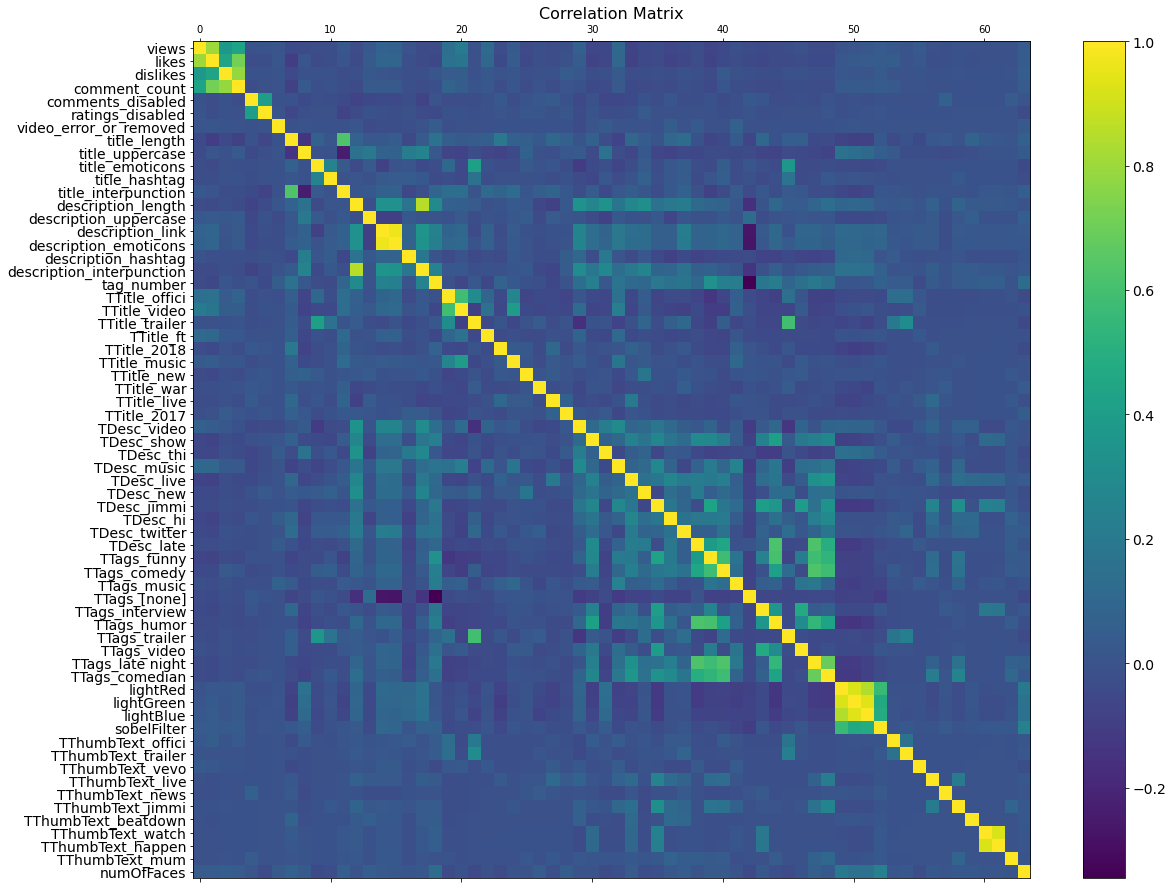

In [16]:
for i in GB_Corr:
    for ii in GB_Corr:
        if (abs(GB_Corr[i][ii]) > 0.6) and (ii != i):
            if GB_Corr[i][ii] > 0:
                print("{}+{} | value: {:.2f}".format(i, ii, GB_Corr[i][ii]))
            else:
                print("{}-{} | value: {:.2f}".format(i, ii, GB_Corr[i][ii]))

f = plt.figure(figsize=(19, 15))
plt.matshow(GB_Corr, fignum=f.number)
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(GB_copy.shape[1]), GB_copy.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

views+likes | value: 0.84
likes+views | value: 0.84
likes+comment_count | value: 0.77
dislikes+comment_count | value: 0.74
comment_count+likes | value: 0.77
comment_count+dislikes | value: 0.74
title_length+title_interpunction | value: 0.66
title_interpunction+title_length | value: 0.66
description_length+description_interpunction | value: 0.89
description_link+description_emoticons | value: 0.98
description_emoticons+description_link | value: 0.98
description_interpunction+description_length | value: 0.89
TDesc_twitter+TDesc_facebook | value: 0.78
TDesc_twitter+TDesc_instagram | value: 0.70
TDesc_facebook+TDesc_twitter | value: 0.78
TDesc_facebook+TDesc_instagram | value: 0.66
TDesc_instagram+TDesc_twitter | value: 0.70
TDesc_instagram+TDesc_facebook | value: 0.66
lightRed+lightGreen | value: 0.91
lightRed+lightBlue | value: 0.81
lightGreen+lightRed | value: 0.91
lightGreen+lightBlue | value: 0.92
lightBlue+lightRed | value: 0.81
lightBlue+lightGreen | value: 0.92
TThumbText_watch+TTh

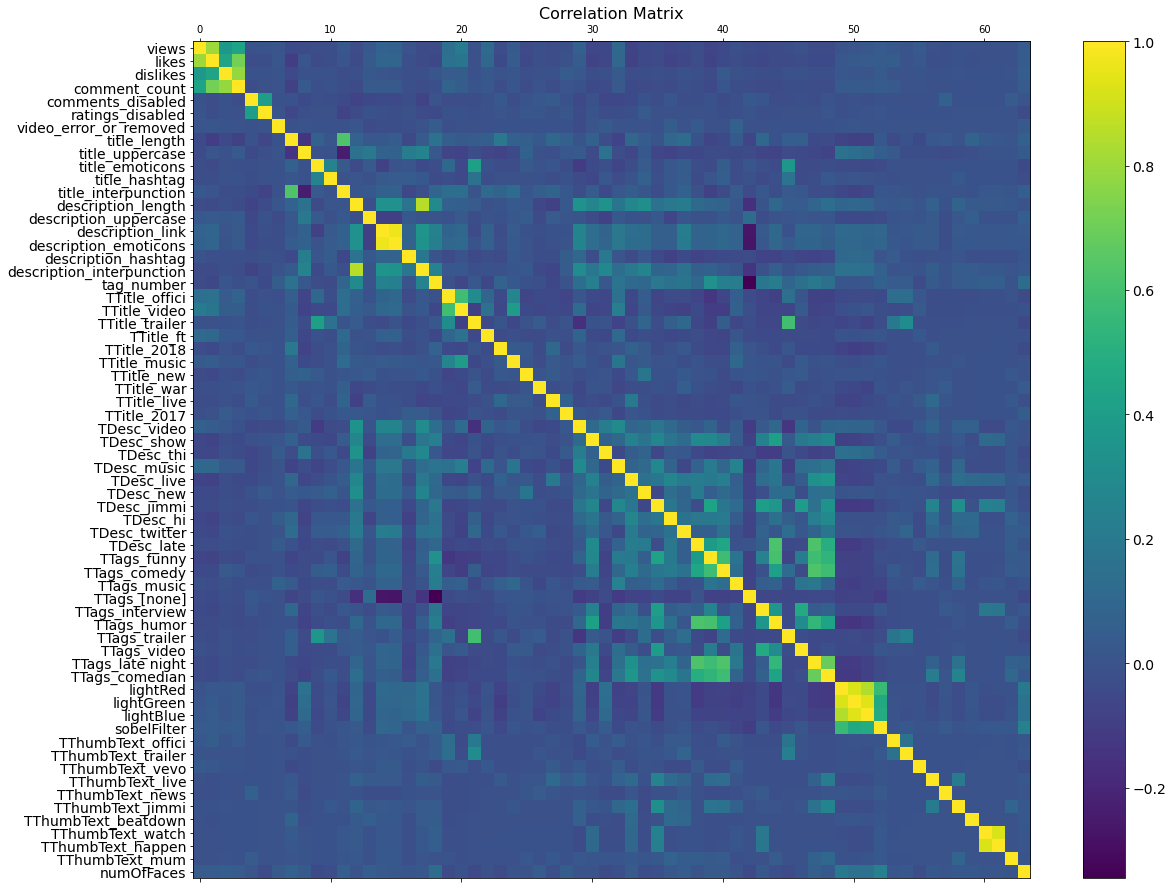

In [17]:
for i in US_Corr:
    for ii in US_Corr:
        if (abs(US_Corr[i][ii]) > 0.6) and (ii != i):
            if US_Corr[i][ii] > 0:
                print("{}+{} | value: {:.2f}".format(i, ii, US_Corr[i][ii]))
            else:
                print("{}-{} | value: {:.2f}".format(i, ii, US_Corr[i][ii]))

f = plt.figure(figsize=(19, 15))
plt.matshow(GB_Corr, fignum=f.number)
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(GB_copy.shape[1]), GB_copy.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

# Korelacja atrybutów z kategoriami

Liczona jest korelacja z atrybutów z kategoriami dla filmów które mają określoną kategorię w wejściowym zbiorze danych.

In [18]:
GB_Corr = A_GB.corr()
US_Corr = A_US.corr()

In [19]:
categories_gb = []
for index, row in gb_videos.iterrows():
    if str(row["category_id"]) != "nan":
        
        if "cat"+str(int(row["category_id"])) not in categories_gb:
            categories_gb.append("cat"+str(int(row["category_id"])))

A_GB_TOCORR = A_GB.copy()

A_GB_TOCORR["category_id"] = gb_videos["category_id"]

A_GB_TOCORR = A_GB_TOCORR[A_GB_TOCORR["category_id"].notnull()]

for i in categories_gb:
    A_GB_TOCORR[i] = A_GB_TOCORR["category_id"].apply(lambda row: "cat"+str(int(row))==i)

In [20]:
categories_us = []
for index, row in us_videos.iterrows():
    if str(row["category_id"]) != "nan":
        
        if "cat"+str(int(row["category_id"])) not in categories_us:
            categories_us.append("cat"+str(int(row["category_id"])))

A_US_TOCORR = A_US.copy()

A_US_TOCORR["category_id"] = us_videos["category_id"]

A_US_TOCORR = A_US_TOCORR[A_US_TOCORR["category_id"].notnull()]

for i in categories_us:
    A_US_TOCORR[i] = A_US_TOCORR["category_id"].apply(lambda row: "cat"+str(int(row))==i)

Program wypisuje na ekranie maksymalną wartość korelacji dla wybranej kategorii. Czym większa wartość maksymalnej korelacji z kategorią tym bardziej dany atrybut wyodrędnia jedną kategorię spośród innych.

In [21]:
GB_CatCorr = A_GB_TOCORR.corr()
GB_CatCorr = GB_CatCorr[categories_gb]
Attr_GB_maxCorr = pd.DataFrame(columns=['Atrybut','maxCorr'])
for x, i in enumerate(A_GB.columns):
    if i == "thumbnailDescription": 
        continue
    else:
        max = GB_CatCorr.loc[i].abs().max()
    Attr_GB_maxCorr = Attr_GB_maxCorr.append({'Atrybut': i, 'maxCorr': max}, ignore_index=True)
Attr_GB_maxCorr.sort_values("maxCorr", ascending=False).head(5000)

,Atrybut,maxCorr
20,TTitle_video,0.432554
21,TTitle_trailer,0.427784
9,title_emoticons,0.412819
44,TTags_humor,0.386461
35,TDesc_jimmi,0.358303
...,...,...
53,TThumbText_offici,0.052673
56,TThumbText_live,0.049470
6,video_error_or_removed,0.048253
62,TThumbText_mum,0.038728


In [22]:
US_CatCorr = A_US_TOCORR.corr()
US_CatCorr = US_CatCorr[categories_us]
Attr_US_maxCorr = pd.DataFrame(columns=['Atrybut','maxCorr'])
for x, i in enumerate(A_US.columns):
    if i == "thumbnailDescription": 
        continue
    else:
        max = US_CatCorr.loc[i].abs().max()
    Attr_US_maxCorr = Attr_US_maxCorr.append({'Atrybut': i, 'maxCorr': max}, ignore_index=True)
Attr_US_maxCorr.sort_values("maxCorr", ascending=False).head(500)

,Atrybut,maxCorr
20,TTitle_video,0.480070
19,TTitle_offici,0.363913
22,TTitle_trailer,0.343770
41,TTags_humor,0.313945
40,TTags_comedy,0.308005
...,...,...
55,TThumbText_origin,0.056737
6,video_error_or_removed,0.050844
62,TThumbText_movi,0.044833
59,TThumbText_watch,0.044833


# Checkpoint 4

In [23]:
AT_GB = pd.read_csv("AT_GB.csv")
AT_US = pd.read_csv("AT_US.csv") 
AG_GB = pd.read_csv("AG_GBv2.csv", index_col = 0)
AG_US = pd.read_csv("AG_USv2.csv", index_col = 0) 

A_GB = pd.concat([AT_GB, AG_GB], axis=1)
A_US = pd.concat([AT_US, AG_US], axis=1)

A_GB = A_GB.set_index("video_id")
A_US = A_US.set_index("video_id")

array = []
for i in range(len(A_GB)):
    if A_GB["thumbnailDescription"][i] not in array:
        array.append(A_GB["thumbnailDescription"][i])
    A_GB["thumbnailDescription"][i] = array.index(A_GB["thumbnailDescription"][i])

array = []
for i in range(len(A_US)):
    if A_US["thumbnailDescription"][i] not in array:
        array.append(A_US["thumbnailDescription"][i])
    A_US["thumbnailDescription"][i] = array.index(A_US["thumbnailDescription"][i])  

CATEGORY_GB = gb_videos["category_id"].apply(lambda row: int(row) if not np.isnan(row) else -1)
CATEGORY_US = us_videos["category_id"].apply(lambda row: int(row) if not np.isnan(row) else -1)

file = open("GB_categories.pkl", "rb")
CATEGORY_GB_TARGET = pickle.load(file)
file.close()
CATEGORY_GB_TARGET_ARRAY = []
for i in CATEGORY_GB.index:
    CATEGORY_GB_TARGET_ARRAY.append(CATEGORY_GB_TARGET[i])


file = open("US_categories.pkl", "rb")
CATEGORY_US_TARGET = pickle.load(file)
file.close()
CATEGORY_US_TARGET_ARRAY = []
for i in CATEGORY_US.index:
    CATEGORY_US_TARGET_ARRAY.append(CATEGORY_US_TARGET[i])

<ipython-input-23-bf5ba5883c16>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][i] = array.index(A_GB["thumbnailDescription"][i])
<ipython-input-23-bf5ba5883c16>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_US["thumbnailDescription"][i] = array.index(A_US["thumbnailDescription"][i])


In [24]:
def calculate_accuracy(target, predicted, training_data):
    good = 0
    examples = 0
    for i in range(len(target)):
        if (int(training_data[i]) != -1) or (target[i] == None):
            pass
        elif int(target[i]) == int(predicted[i]):
            examples += 1
            good += 1
        else:
            examples += 1
    return good/examples

## Self training

In [29]:
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

y = []
x = []
for i in range(63):
    A_GB = pd.concat([AT_GB, AG_GB], axis=1)

    A_GB = A_GB.set_index("video_id")

    array = []
    for ii in range(len(A_GB)):
        if A_GB["thumbnailDescription"][ii] not in array:
            array.append(A_GB["thumbnailDescription"][ii])
        A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])


    for ii in Attr_GB_maxCorr.sort_values("maxCorr", ascending=False).tail(i)["Atrybut"]:
        del A_GB[ii]
    
    svc = KNeighborsClassifier(n_neighbors=5)
    self_training_model = SelfTrainingClassifier(svc)
    self_training_model.fit(np.array(A_GB), np.array(CATEGORY_GB))
    
    PREDICTED_GB_SELF_TRAINING = self_training_model.predict(A_GB)
    y.append(100*calculate_accuracy(CATEGORY_GB_TARGET_ARRAY, PREDICTED_GB_SELF_TRAINING, CATEGORY_GB))
    x.append(len(A_GB.columns))


<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii

<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii

<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
<ipython-input-29-092da7a0c57d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii

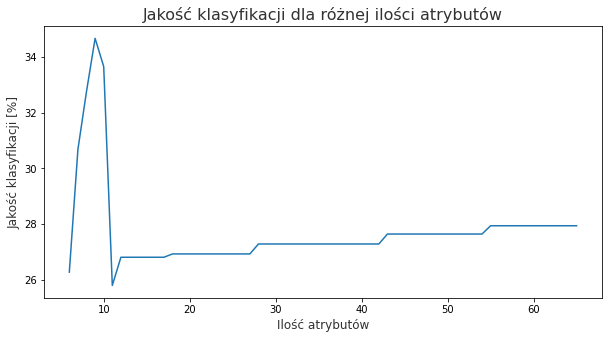

In [30]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.xlabel('Ilość atrybutów', fontsize=12, color='#323232')
plt.ylabel('Trafność klasyfikacji [%]', fontsize=12, color='#323232')
plt.title('Trafność klasyfikacji dla różnej ilości atrybutów', fontsize=16, color='#323232')

plt.show();

In [28]:
def showAccuracies(target, predicted, training_data):
    good = {}
    examples = {}  
    for i in range(len(target)):
        if target[i] not in examples.keys():
            examples[target[i]] = 0
            good[target[i]] = 0
        
        if (int(training_data[i]) != -1) or (target[i] == None):
            pass
        elif int(target[i]) == int(predicted[i]):
            examples[target[i]] += 1
            good[target[i]] += 1
        else:
            examples[target[i]] += 1
    
    for i in examples.keys():
        if examples[i] == 0:
            good[i] = None
        else:
            good[i] = good[i]/examples[i]*100
    del good[None]
    
    y_pos = np.arange(len(good.keys()))
    height = []
    bars = []
    for w in sorted(good, key=good.get, reverse=True):
        height.append(good[w])
        bars.append(us_category_dict[w])
    plt.figure(figsize=(10,5))
    plt.barh(y_pos, height, color = '#969696')
    plt.yticks(y_pos, bars)
    plt.xlabel('Kategoria', fontsize=12, color='#323232')
    plt.ylabel('Trafność klasyfikacji [%]', fontsize=12, color='#323232')
    plt.title('Trafność klasyfikacji dla kolejnych kategorii', fontsize=16, color='#323232')

    plt.show();
    return good

<ipython-input-32-11bd62c77280>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])


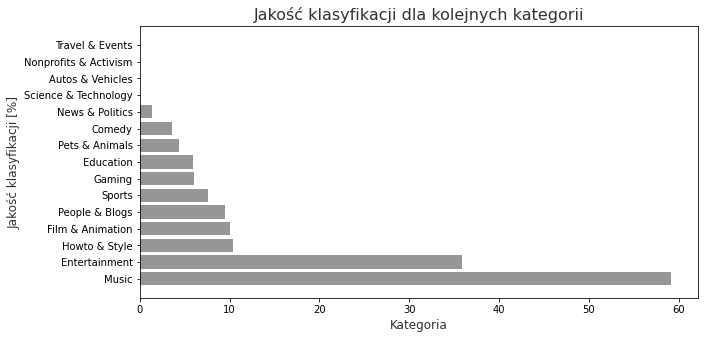

{'22': 9.523809523809524,
 '24': 35.85746102449889,
 '17': 7.633587786259542,
 '10': 59.164733178654295,
 '20': 6.0,
 '1': 10.0,
 '26': 10.377358490566039,
 '25': 1.3333333333333335,
 '23': 3.5294117647058822,
 '27': 5.88235294117647,
 '15': 4.3478260869565215,
 '28': 0.0,
 '2': 0.0,
 '29': 0.0,
 '19': 0.0}

In [32]:
A_GB = pd.concat([AT_GB, AG_GB], axis=1)
A_GB = A_GB.set_index("video_id")

array = []
for ii in range(len(A_GB)):
    if A_GB["thumbnailDescription"][ii] not in array:
        array.append(A_GB["thumbnailDescription"][ii])
    A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])

svc = KNeighborsClassifier(n_neighbors=5)
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(np.array(A_GB), np.array(CATEGORY_GB))

PREDICTED_GB_SELF_TRAINING = self_training_model.predict(A_GB)

showAccuracies(CATEGORY_GB_TARGET_ARRAY, PREDICTED_GB_SELF_TRAINING, CATEGORY_GB)

## Label Spreading

In [25]:
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading 

y = []
x = []
for i in range(63):
    A_GB = pd.concat([AT_GB, AG_GB], axis=1)

    A_GB = A_GB.set_index("video_id")

    array = []
    for ii in range(len(A_GB)):
        if A_GB["thumbnailDescription"][ii] not in array:
            array.append(A_GB["thumbnailDescription"][ii])
        A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])

    for ii in Attr_GB_maxCorr.sort_values("maxCorr", ascending=False).tail(i)["Atrybut"]:
        del A_GB[ii]
    
    label_prop_model = LabelSpreading()
    label_prop_model.fit(A_GB, CATEGORY_GB)
    
    PREDICTED_GB_LABEL_PROP = label_prop_model.predict(A_GB)
    y.append(100*calculate_accuracy(CATEGORY_GB_TARGET_ARRAY, PREDICTED_GB_LABEL_PROP, CATEGORY_GB))
    x.append(len(A_GB.columns))

<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_sup

c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])
c:\users\adrian\appdata\local\programs\python\python38\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

<ipython-input-25-91f92b8323ad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])


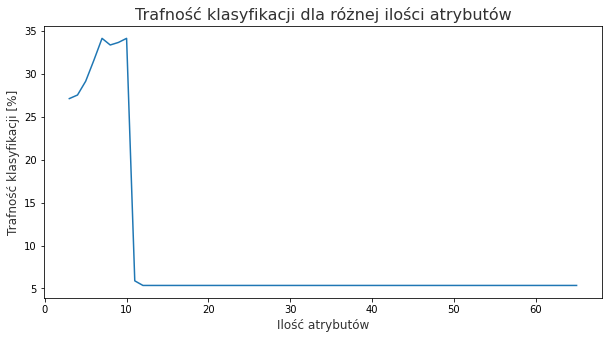

In [26]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.xlabel('Ilość atrybutów', fontsize=12, color='#323232')
plt.ylabel('Trafność klasyfikacji [%]', fontsize=12, color='#323232')
plt.title('Trafność klasyfikacji dla różnej ilości atrybutów', fontsize=16, color='#323232')

plt.show();

<ipython-input-29-fabdd5ad66dd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])


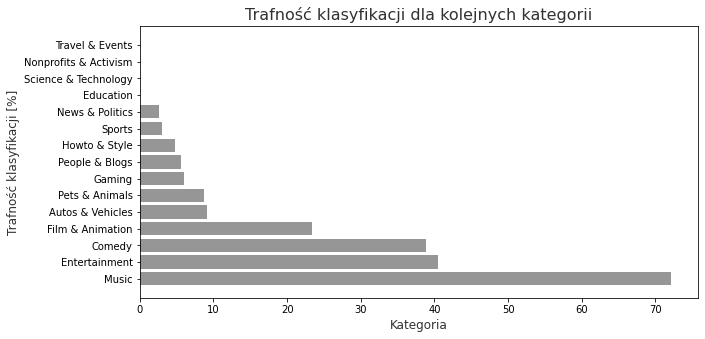

{'22': 5.555555555555555,
 '24': 40.53452115812918,
 '17': 3.0534351145038165,
 '10': 72.15777262180974,
 '20': 6.0,
 '1': 23.333333333333332,
 '26': 4.716981132075472,
 '25': 2.666666666666667,
 '23': 38.82352941176471,
 '27': 0.0,
 '15': 8.695652173913043,
 '28': 0.0,
 '2': 9.090909090909092,
 '29': 0.0,
 '19': 0.0}

In [29]:
A_GB = pd.concat([AT_GB, AG_GB], axis=1)
A_GB = A_GB.set_index("video_id")

array = []
for ii in range(len(A_GB)):
    if A_GB["thumbnailDescription"][ii] not in array:
        array.append(A_GB["thumbnailDescription"][ii])
    A_GB["thumbnailDescription"][ii] = array.index(A_GB["thumbnailDescription"][ii])

for ii in Attr_GB_maxCorr.sort_values("maxCorr", ascending=False).tail(55)["Atrybut"]:
    del A_GB[ii]  
    
label_prop_model = LabelSpreading()
label_prop_model.fit(A_GB, CATEGORY_GB)    
    
PREDICTED_GB_LABEL_PROP = label_prop_model.predict(A_GB)

showAccuracies(CATEGORY_GB_TARGET_ARRAY, PREDICTED_GB_LABEL_PROP, CATEGORY_GB)